# Imports

In [1]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14832540610092348365, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2431025890073484559
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10768669797542927343
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10924684084
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 12130800170870273120
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10924684084
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
   }
 }

In [1]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.

It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''

from __future__ import print_function

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import csv
import keras
import numpy as np
from keras import regularizers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from itertools import chain
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

def limit_mem():
    keras.backend.get_session().close()
    cfg = keras.backend.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    keras.backend.set_session(keras.backend.tf.Session(config=cfg))

print(get_available_gpus())
limit_mem()

['/device:GPU:0']


In [6]:
from enum import Enum
class WeightsTypeEnum(Enum):
        WEIGHTS = 1
        BIAS = 2
        WEIGHTS_BIAS = 3

def generate_layer_mask(active_layers, layers_num):
    layer_mask = [0] * layers_num
    for layer in active_layers:
        layer_mask[layer] = 1
    return layer_mask

def show_weights_distribution(cnn_model, layer_mask, weights_type=WeightsTypeEnum.WEIGHTS, xrange=0.4):
    all_weights = []
    layer_mask_index = 0
    
    for x in cnn_model.layers:
        if(x.get_weights() and layer_mask[layer_mask_index] == 1) :
            layer_weights, layer_bias = x.get_weights()
            if weights_type == WeightsTypeEnum.WEIGHTS:
                all_weights.append(np.reshape(layer_weights, -1))
            elif weights_type == WeightsTypeEnum.BIAS:
                all_weights.append(np.reshape(layer_bias, -1))
            elif weights_type == WeightsTypeEnum.WEIGHTS_BIAS:
                all_weights.append(np.reshape(layer_weights, -1))
                all_weights.append(np.reshape(layer_bias, -1))
            else:
                print('Some trouble in show_weights_distribution!')
        layer_mask_index += 1
    
    all_weights = np.concatenate(all_weights)
    plt.hist(all_weights, bins=80, range=(-xrange, xrange))

def get_threshold(zero_part, cnn_model, layer_mask, weights_type=WeightsTypeEnum.WEIGHTS):
    all_weights = []
    layer_mask_index = 0
    
    for x in cnn_model.layers:
        if(x.get_weights() and layer_mask[layer_mask_index] == 1) :
            layer_weights, layer_bias = x.get_weights()
            if weights_type == WeightsTypeEnum.WEIGHTS:
                all_weights.append(np.reshape(layer_weights, -1))
            elif weights_type == WeightsTypeEnum.BIAS:
                all_weights.append(np.reshape(layer_bias, -1))
            elif weights_type == WeightsTypeEnum.WEIGHTS_BIAS:
                all_weights.append(np.reshape(layer_weights, -1))
                all_weights.append(np.reshape(layer_bias, -1))
            else:
                print('Some trouble in get_threshold!')
        layer_mask_index += 1
            
    all_weights = np.abs(np.concatenate(all_weights))
    all_weights = np.sort(all_weights)
    threshold_value = all_weights[int(zero_part * len(all_weights)) + 1]
    return threshold_value
    
def get_masks(cnn_model, threshold_value, layer_mask, weights_type=WeightsTypeEnum.WEIGHTS):
    zero_masks = []
    layer_mask_index = 0
    
    for x in cnn_model.layers:
        if(x.get_weights() and layer_mask[layer_mask_index] == 1) :
            layer_weights, layer_bias = x.get_weights()
            if weights_type == WeightsTypeEnum.WEIGHTS:
                zero_masks.append(np.abs(layer_weights) <= threshold_value)
            elif weights_type == WeightsTypeEnum.BIAS:
                zero_masks.append(np.abs(layer_bias) <= threshold_value)
            elif weights_type == WeightsTypeEnum.WEIGHTS_BIAS:
                zero_masks.append(np.abs(layer_weights) <= threshold_value)
                zero_masks.append(np.abs(layer_bias) <= threshold_value)
            else:
                print('Some trouble in get_masks!')
        layer_mask_index += 1
            
    return zero_masks

def set_null_weights_by_mask(cnn_model, zero_mask, layer_mask, weights_type=WeightsTypeEnum.WEIGHTS):
    mask_iter = 0
    layer_mask_index = 0
    
    for x in cnn_model.layers:
        if(x.get_weights() and layer_mask[layer_mask_index] == 1) :
            layer_weights, layer_bias = x.get_weights()
            if weights_type == WeightsTypeEnum.WEIGHTS:
                layer_weights[zero_mask[mask_iter]] = 0
            elif weights_type == WeightsTypeEnum.BIAS:
                layer_bias[zero_mask[mask_iter]] = 0
            elif weights_type == WeightsTypeEnum.WEIGHTS_BIAS:
                layer_weights[zero_mask[mask_iter]] = 0
                mask_iter += 1
                layer_bias[zero_mask[mask_iter]] = 0
            else:
                print('Some trouble in set_null_weights_by_mask!')
            mask_iter += 1
            x.set_weights([layer_weights, layer_bias])
        layer_mask_index += 1
        
    return cnn_model

# Model achitecture

In [7]:
batch_size = 32
num_classes = 10
epochs = 50
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
l1_coef = 0.0001 # * 10, * 100, * ??? was 0.00001
min_los_delta = 0.001

# 01 version - stock model, dropouts, no L1/L2
# 02 version - stock model, no dropouts, no L1/L2
# 03 version - stock model, no dropouts, L1 0.01 kernel_regularizer

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', 
                 input_shape=x_train.shape[1:]))#, kernel_regularizer=regularizers.l1(l1_coef))) # Layer 0
model.add(Activation('relu')) # Layer 1
model.add(Conv2D(32, (3, 3)))#, kernel_regularizer=regularizers.l1(l1_coef))) # Layer 2
model.add(Activation('relu')) # Layer 3
model.add(MaxPooling2D(pool_size=(2, 2))) # Layer 4
model.add(Dropout(0.25)) # Layer 5

model.add(Conv2D(64, (3, 3), padding='same'))#, kernel_regularizer=regularizers.l1(l1_coef))) # Layer 6
model.add(Activation('relu')) # Layer 7
model.add(Conv2D(64, (3, 3)))#, kernel_regularizer=regularizers.l1(l1_coef))) # Layer 8
model.add(Activation('relu')) # Layer 9
model.add(MaxPooling2D(pool_size=(2, 2))) # Layer 10
model.add(Dropout(0.25)) # Layer 11

model.add(Flatten()) # Layer 12
model.add(Dense(512))#, kernel_regularizer=regularizers.l1(l1_coef)))  # Layer 13
model.add(Activation('relu'))  # Layer 14
model.add(Dropout(0.5))  # Layer 15 
model.add(Dense(num_classes))#, kernel_regularizer=regularizers.l1(l1_coef)))  # Layer 16
model.add(Activation('softmax'))  # Layer 17


# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
# maybe adam, /5 or /10 default parametrs

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, "empty_model")
model.save(model_path)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


# Callbacks

In [8]:
cb_lists = [
    EarlyStopping(monitor='val_loss', 
                  min_delta=0.1 * min_los_delta, 
                  patience=10, 
                  verbose=0, 
                  mode='auto', 
                  baseline=None, 
                  restore_best_weights=False)
]

# Example Loop

In [9]:
def example_loop():
    if not data_augmentation:
        print('Not using data augmentation.')
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)
    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)
    
        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)
    
        # Fit the model on the batches generated by datagen.flow().
        model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            workers=4,
                            steps_per_epoch=len(x_train)/batch_size,
                            callbacks=cb_lists)

# Custom Loop

In [10]:
def custom_loop(model, zero_part, log_file_name):
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    
    enable_early_cut_off = False
    enable_saving_best_model = True
    prev_loss = 0
    best_loss = 999999999999
    best_acc = 0
    
    # Zeroing weights params
    enable_zeroing_weights = True
    zero_mode = False
    zero_mask = None
    layers_to_zero = generate_layer_mask([0, 2, 6, 8], len(model.layers))
    # 0, 2, 6, 8 - conv layers
    # 13, 16 - dense layers
    weights_type = WeightsTypeEnum.WEIGHTS
    # WEIGHTS, BIAS, WEIGHTS_BIAS
    
    usual_epochs = 5
    zeroing_epochs = 5
    first_loop_iters = 3
    real_epoch_counter = 0
    
    for i in range(0, first_loop_iters):
        # Usual epochs:
        for j in range(0, usual_epochs):
            gen = datagen.flow(x_train, y_train, batch_size=batch_size)
        
            for k in range(0, int(len(x_train)/batch_size)):
                x_tr, y_tr = next(gen)
                model.train_on_batch(x_tr, y_tr)
            real_epoch_counter += 1
        
            print('Finish usuall epoch: ' + str(real_epoch_counter) + "_" + str(i) + "_" + str(j))
            epoch_loss, epoch_acc = model.evaluate(x_test, y_test)
            print('Validation loss: ' + str(epoch_loss) + ', acc ' + str(epoch_acc))
            
            with open(log_file_name, 'a', newline='') as f:
                writer = csv.writer(f)
#                 writer.writerow(["{:2.2f}".format(0.0)] + [str(epoch_loss)] + [str(epoch_acc)])
                writer.writerow([str(0)] + [str(epoch_loss)] + [str(epoch_acc)])
        
#             if (enable_early_cut_off):
#                 if (abs(epoch_loss - prev_loss) < min_los_delta):
#                     print('Exit because loss stoped changing. epoch_loss ' 
#                           + str(epoch_loss) 
#                           + ' prev_loss' 
#                           + str(prev_loss))
#                     break
#                 prev_loss = epoch_loss        
#             if(enable_saving_best_model):
#                 if(epoch_loss < best_loss):
#                     best_loss = epoch_loss
#                     best_acc = epoch_acc
                
#                     if not os.path.isdir(save_dir):
#                         os.makedirs(save_dir)
#                     model_path = os.path.join(save_dir, model_name)
#                     model.save(model_path)
#                     print('Saved best model at %s ' % model_path)
                    
        # Zeroing epochs:
        for j in range(0, zeroing_epochs):
            gen = datagen.flow(x_train, y_train, batch_size=batch_size)
            
            if zero_mask is None:
                zero_mask = get_masks(model, get_threshold(zero_part, model, layers_to_zero, weights_type), 
                                          layers_to_zero, weights_type)
#                 print('Generate zero mask! ' + str(zero_mask))
        
            for k in range(0, int(len(x_train)/batch_size)):
                x_tr, y_tr = next(gen)
                model.train_on_batch(x_tr, y_tr)
                model = set_null_weights_by_mask(model, zero_mask, layers_to_zero, weights_type)
            real_epoch_counter += 1
        
            print('Finish zeroing epoch: ' + str(real_epoch_counter) + "_"  + str(i) + "_" + str(j))
            epoch_loss, epoch_acc = model.evaluate(x_test, y_test)
            print('Validation loss: ' + str(epoch_loss) + ', acc ' + str(epoch_acc))
            
            with open(log_file_name, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([str(1)] + [str(epoch_loss)] + [str(epoch_acc)])
        zero_mask = None
        
    for i in range(0, int((epochs - first_loop_iters * (usual_epochs + zeroing_epochs)) / zeroing_epochs)):
        # Zeroing epochs:
        for j in range(0, zeroing_epochs):
            gen = datagen.flow(x_train, y_train, batch_size=batch_size)
            
            if zero_mask is None:
                zero_mask = get_masks(model, get_threshold(zero_part, model, layers_to_zero, weights_type), 
                                          layers_to_zero, weights_type)
                print('Generate zero mask! ' + str(len(zero_mask)))
        
            for k in range(0, int(len(x_train)/batch_size)):
                x_tr, y_tr = next(gen)
                model.train_on_batch(x_tr, y_tr)
                model = set_null_weights_by_mask(model, zero_mask, layers_to_zero, weights_type)
            real_epoch_counter += 1
        
            print('Finish zeroing epoch: ' + str(real_epoch_counter) + "_"  + str(i) + "_" + str(j))
            epoch_loss, epoch_acc = model.evaluate(x_test, y_test)
            print('Validation loss: ' + str(epoch_loss) + ', acc ' + str(epoch_acc))
            
            with open(log_file_name, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([str(1)] + [str(epoch_loss)] + [str(epoch_acc)])
        zero_mask = None
                       
    return model

# Just one loop

In [ ]:
model.reset_states() 

zero_part = 0.80
result_model = custom_loop(model, zero_part, "0.8z_test.csv")

Finish usuall epoch: 1_0_0
10000/10000 [==============================] - 1s 57us/step
Validation loss: 1.564589080810547, acc 0.4333
Finish usuall epoch: 2_0_1
10000/10000 [==============================] - 1s 52us/step
Validation loss: 1.395146474647522, acc 0.4947
Finish usuall epoch: 3_0_2
10000/10000 [==============================] - 0s 50us/step
Validation loss: 1.2964703170776368, acc 0.5331
Finish usuall epoch: 4_0_3
10000/10000 [==============================] - 1s 51us/step
Validation loss: 1.2001657182693481, acc 0.5768
Finish usuall epoch: 5_0_4
10000/10000 [==============================] - 0s 46us/step
Validation loss: 1.2723612516403198, acc 0.5601


# Active cell with different zero part [NOT IN USE]

In [ ]:
model_name_prefix = '60_99_cf10_conv_w2_'
zero_step_big = 0.1
zero_step_small = 0.02
zero_part_start = 0.5
zero_part_end = 1

zero_part = zero_part_start

while(zero_part < zero_part_end):
    print('Zero part is ' + "{:2.2f}".format(zero_part))
    model = keras.models.load_model('saved_models/empty_model')
    model_name = model_name_prefix + "{:2.2f}".format(zero_part) + '_zeroed'
    loss_result, acc_result = custom_loop(model, zero_part)
    print('After runs, ' + str(loss_result) + ' loss and ' + str(acc_result) + ' acc')
    with open(model_name_prefix + '_res.csv', 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["{:2.2f}".format(zero_part)] + [str(loss_result)] + [str(acc_result)])
    if zero_part < 0.9 - 0.5 * zero_step_big:
        zero_part += zero_step_big
    else:
        zero_part += zero_step_small
        
#limit_mem()

# Load best model
#model = keras.models.load_model('saved_models/keras_cifar10_trained_03.h5')
#scores = model.evaluate(x_test, y_test, verbose=1)
#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])

Zero part is 0.50
Finish epoch: 0
10000/10000 [==============================] - 1s 54us/step
Validation loss: 1.5676969532012939, acc 0.4312
Saved best model at /home/nikitam/sparse-net-study/saved_models/60_99_cf10_conv_w2_0.50_zeroed 
Finish epoch: 1
10000/10000 [==============================] - 0s 47us/step
Validation loss: 1.425840477180481, acc 0.4868
Saved best model at /home/nikitam/sparse-net-study/saved_models/60_99_cf10_conv_w2_0.50_zeroed 
Finish epoch: 2
10000/10000 [==============================] - 0s 47us/step
Validation loss: 1.3089456159591675, acc 0.5345
Saved best model at /home/nikitam/sparse-net-study/saved_models/60_99_cf10_conv_w2_0.50_zeroed 
Finish epoch: 3
10000/10000 [==============================] - 0s 50us/step
Validation loss: 1.2282586935043336, acc 0.5616
Saved best model at /home/nikitam/sparse-net-study/saved_models/60_99_cf10_conv_w2_0.50_zeroed 
Finish epoch: 4
10000/10000 [==============================] - 0s 47us/step
Validation loss: 1.16967273

Finish epoch: 46
10000/10000 [==============================] - 0s 49us/step
Validation loss: 0.7325900618553162, acc 0.7546
Finish epoch: 47
10000/10000 [==============================] - 0s 48us/step
Validation loss: 0.751515657711029, acc 0.7548
Finish epoch: 48
10000/10000 [==============================] - 0s 48us/step
Validation loss: 0.809251259803772, acc 0.7293


# Check zeroing

In [ ]:
show_weights_distribution(model, layers_to_zero) 

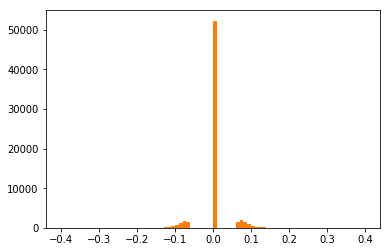

In [15]:
first_model = model
layers_to_zero = generate_layer_mask([0, 2, 6, 8], len(first_model.layers)) # only conv layers
zero_part = 0.8

weights_type = WeightsTypeEnum.WEIGHTS
zero_mask = get_masks(first_model, get_threshold(zero_part, first_model, layers_to_zero, weights_type), 
                                          layers_to_zero, weights_type)
second_model = set_null_weights_by_mask(first_model, zero_mask, layers_to_zero, weights_type)

show_weights_distribution(first_model, layers_to_zero) 
show_weights_distribution(second_model, layers_to_zero) 

# Another useless cells

In [ ]:
#!jupyter notebook stop 11440
os._exit(0)

In [ ]:
#Load model and show it's score
model = keras.models.load_model('saved_models/keras_cifar10_trained_02.h5')

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
with open('results.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        print(', '.join(row))

In [ ]:
model = keras.models.load_model('saved_models/keras_cf10_0.9500000000000003zrpt')

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

show_weights_distribution(1) # NEED UPDATE

In [ ]:
model.summary()

In [9]:
from keras.utils import plot_model
plot_model(model, to_file='model_2.png', show_shapes=True, show_layer_names=True)

In [ ]:
!pip uninstall GraphViz